In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import tqdm
import spacepy.toolbox as tb

%matplotlib inline

# Setup a convolution data set and try and doconvolve it


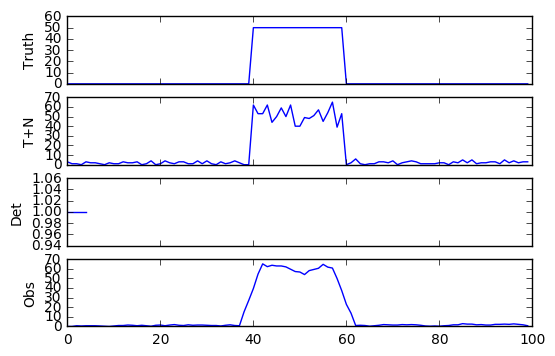

In [39]:
np.random.seed(8675309)

dat_len = 100
xval = np.arange(dat_len)
realdat = np.zeros(dat_len, dtype=int)
realdat[40:60] = 50
noisemean = 2
real_n = np.zeros_like(realdat)
for i in range(len(realdat)):
    real_n[i] = np.random.poisson(realdat[i]+noisemean)


# make a detector
# triangular with FWFM 5 and is square
det = np.array([1,1,1,1,1])

# the numpy convolve I don't understand the normalization
obs = np.convolve(real_n, det, mode='same')
obs = tb.normalize(obs)
obs *= real_n.max()
    
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(4, sharex=True)
axarr[0].plot(xval, realdat)
axarr[0].set_ylabel('Truth')
axarr[0].set_ylim((0,60))

axarr[1].plot(xval, real_n)
axarr[1].set_ylabel('T+N')

axarr[2].plot(np.arange(len(det)), det)
axarr[2].set_ylabel('Det')

axarr[3].plot(xval, obs)
axarr[3].set_ylabel('Obs')




So the det provides a point spread function that is U(0,5)

In [44]:
# generate some data
with pm.Model() as model:
    truth_mc = pm.Uniform('truth', 0, 100, shape=dat_len)
    noisemean_mc = pm.Uniform('noisemean', 0, 100)
    noise_mc = pm.Poisson('noise', noisemean_mc, observed=obs[1:20])
    real_n_mc = pm.Poisson('real_n', truth_mc+noisemean_mc, shape=dat_len)
    psf = pm.Uniform('psf', 0, 5, observed=det)
    obs_mc = pm.Normal('obs', (truth_mc+noisemean_mc)*psf.max(), 1/5**2, observed=obs, shape=dat_len)
    
    trace = pm.sample(5000)



Applied interval-transform to truth and added transformed truth_interval_ to model.
Applied interval-transform to noisemean and added transformed noisemean_interval_ to model.
Assigned NUTS to truth_interval_
Assigned NUTS to noisemean_interval_
Assigned Metropolis to real_n
 [-----------------100%-----------------] 5000 of 5000 complete in 20.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x186786e48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x188513a58>]], dtype=object)

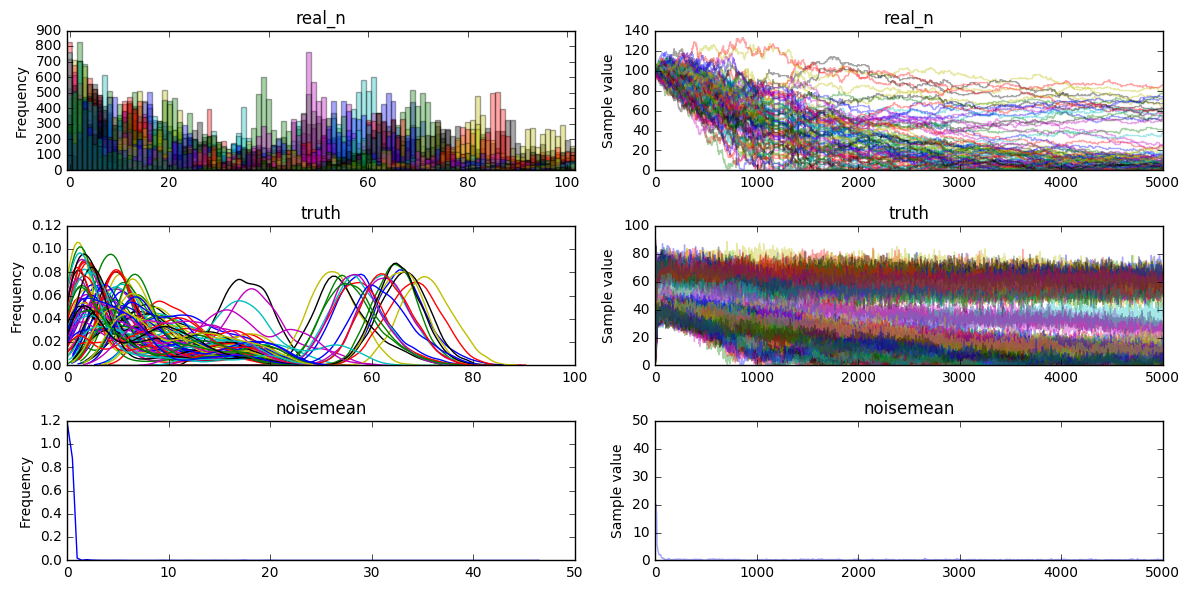

In [45]:
pm.traceplot(trace)


In [46]:
pm.summary(trace)


real_n:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  22.053           24.462           2.442            [0.000, 81.000]
  14.330           20.935           2.088            [0.000, 72.000]
  13.760           20.308           2.024            [0.000, 69.000]
  34.145           26.765           2.672            [5.000, 98.000]
  35.526           28.548           2.851            [0.000, 89.000]
  35.915           31.123           3.109            [1.000, 92.000]
  39.125           23.811           2.376            [6.000, 94.000]
  26.210           29.557           2.951            [0.000, 98.000]
  32.137           26.551           2.651            [0.000, 89.000]
  51.525           25.033           2.499            [22.000, 98.000]
  28.203           24.434           2.438            [4.000, 86.000]
  29.116           28.007           2.797            [0.000, 88.000]
  23.918          

ValueError: x and y must have same first dimension

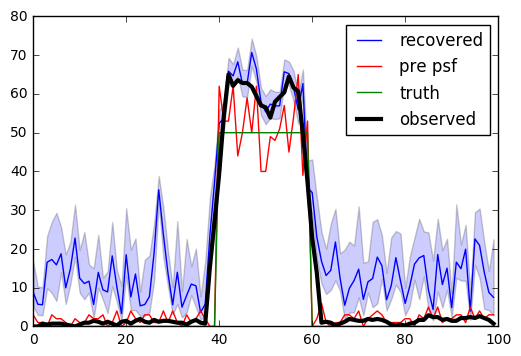

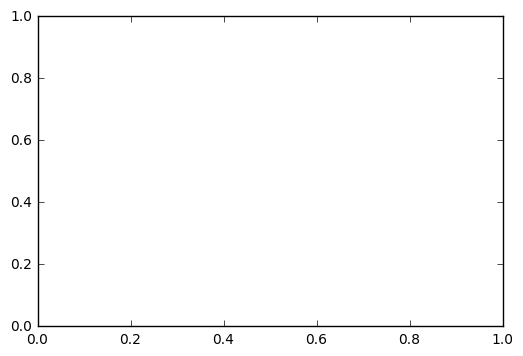

In [50]:
# plt.plot(trace['truth'][0:5,:].T)
trace['truth'].shape
iqr = np.zeros((dat_len,3))
for i in range(dat_len):
    iqr[i] = np.percentile(trace['truth'].T[i], (25,50,75), axis=0)
plt.plot(xval, iqr[:,1],  label='recovered')
plt.fill_between(xval, iqr[:,0], iqr[:,2], alpha=0.2)
plt.plot(xval, real_n, c='r', label='pre psf')
plt.plot(xval, realdat, c='g',  label='truth')
plt.plot(xval, obs, c='k',  label='observed', lw=3)

plt.legend()
plt.figure()
snr = iqr[:,1]/(iqr[:,2], iqr[:,0])
perixval.shape, snr.shape
plt.plot(xval, snr)

In [48]:
print(np.percentile(trace['noisemean'], (25,50,75)), noisemean)

[ 0.16863086  0.23445815  0.3197733 ] 2


In [49]:
obs[1:20]

array([ 0.        ,  0.72490706,  0.48327138,  0.72490706,  0.72490706,
        0.72490706,  0.48327138,  0.24163569,  0.        ,  0.48327138,
        0.96654275,  0.96654275,  1.44981413,  1.20817844,  0.72490706,
        1.20817844,  0.72490706,  0.24163569,  1.20817844])